# Analisis con Prophet

## Importacion de la data

In [2]:
import pandas as pd
import numpy as np
df_news=pd.read_csv("../Datos/noticias_bitcoin_sentimientos.csv")#../Datos/noticias_bitcoin_sentimientos.csv
df_btc=pd.read_csv("../Datos/BTC_USD_Media_Movil.csv")#../Datos/BTC_USD_Media_Movil.csv
df_btc['Date']=pd.to_datetime(df_btc['Date'], format='%Y-%m-%d')
df_btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1096 non-null   datetime64[ns]
 1   Close      1096 non-null   float64       
 2   High       1096 non-null   float64       
 3   Low        1096 non-null   float64       
 4   Open       1096 non-null   float64       
 5   Volume     1096 non-null   float64       
 6   Close_7d   1090 non-null   float64       
 7   Volume_7d  1090 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 68.7 KB


In [3]:
df_news['fecha'] = pd.to_datetime(df_news['fecha'], format='%Y-%m-%d')

df_news_avg_score = df_news.groupby('fecha')['score'].mean().reset_index()

In [4]:
df_model=df_btc[['Date','Close']]
df_model = pd.merge(df_model, df_news_avg_score, how='left', left_on='Date', right_on='fecha')
df_model.fillna(0, inplace=True)
df_model.drop(columns=['fecha'], inplace=True)
df_model['Date'] = pd.to_datetime(df_model['Date'])

C:\Users\SANTI\AppData\Local\Temp\ipykernel_20364\1242759099.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df_model.fillna(0, inplace=True)


In [5]:

df_model = df_model.iloc[1:]



## Implementacion del modelo

In [7]:
!pip install prophet


[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 1 to 1096
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1096 non-null   datetime64[ns]
 1   Close   1096 non-null   float64       
 2   score   1096 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 25.8 KB


In [8]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt


c:\Users\SANTI\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Renombrar columnas a las que espera Prophet
df = df_model.rename(columns={
    'Date': 'ds',
    'Close': 'y'
})

# Asegurar que 'ds' sea datetime
df['ds'] = pd.to_datetime(df['ds'])

# Verificar que no haya valores nulos
print(df.isnull().sum())

ds       0
y        0
score    0
dtype: int64


In [22]:
# Crear el modelo Prophet con un regresor externo
modelo = Prophet(
    growth='linear',               # Tipo de crecimiento: 'linear' o 'logistic'
    changepoint_prior_scale=0.09,  # Flexibilidad para cambios en la tendencia
    changepoint_range=0.8,         # Proporción del historial donde se permiten cambios
    yearly_seasonality='auto',     # Estacionalidad anual: True/False/'auto'
    weekly_seasonality='auto',     # Estacionalidad semanal
    daily_seasonality='auto',      # Estacionalidad diaria
    seasonality_mode='additive',   # 'additive' o 'multiplicative'
    seasonality_prior_scale=10.0,  # Regularización para la estacionalidad
    holidays_prior_scale=10.0,     # Regularización para efectos de festivos
    interval_width=0.80,           # Ancho del intervalo de confianza
    uncertainty_samples=1000       # Número de muestras para intervalos de incertidumbre
)
modelo.add_regressor('score')

# Entrenar el modelo
modelo.fit(df)

22:32:05 - cmdstanpy - INFO - Chain [1] start processing
22:32:06 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
# Crear fechas futuras para predecir
futuro = modelo.make_future_dataframe(periods=7)  # 30 días hacia adelante

# Agregar las temperaturas futuras al dataframe
# Aquí debes tener una forma de estimarlas o simularlas
# En este ejemplo usamos la media histórica como placeholder
media_temp = df['score'].mean()
futuro['score'] = list(df['score']) + [media_temp]*7

# Predecir
pronostico = modelo.predict(futuro)

In [25]:
import plotly.graph_objects as go

# Crear figura
fig = go.Figure()

# Línea de predicción central (yhat)
fig.add_trace(go.Scatter(
    x=pronostico['ds'][-60:],
    y=pronostico['yhat'][-60:],
    mode='lines',
    name='Predicción (yhat)',
    line=dict(color='blue')
))

# Banda de incertidumbre: yhat_lower
fig.add_trace(go.Scatter(
    x=pronostico['ds'][-60:],
    y=pronostico['yhat_upper'][-60:],
    mode='lines',
    name='Límite Superior (yhat_upper)',
    line=dict(color='green', dash='dash'),
    showlegend=True
))

fig.add_trace(go.Scatter(
    x=pronostico['ds'][-60:],
    y=pronostico['yhat_lower'][-60:],
    mode='lines',
    name='Límite Inferior (yhat_lower)',
    line=dict(color='orange', dash='dash'),
    fill='tonexty',  # Rellena entre esta traza y la anterior
    fillcolor='rgba(255,165,0,0.2)',
    showlegend=True
))

# Datos reales (si están disponibles)
if 'y' in df.columns:
    fig.add_trace(go.Scatter(
        x=df['ds'],
        y=df['y'],
        mode='lines',
        name='Datos Reales',
        line=dict(color='black', width=2),
        opacity=0.6
    ))

# Layout del gráfico
fig.update_layout(
    title='Predicción de Bitcoin con Prophet + score',
    xaxis_title='Fecha',
    yaxis_title='Precio',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    height=500
)

fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [14]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Unimos el dataframe original (df) con las predicciones para fechas pasadas
df_evaluacion = pd.merge(df[['ds', 'y']], pronostico[['ds', 'yhat']], on='ds')

# Calcular MSE y RMSE
mse = mean_squared_error(df_evaluacion['y'], df_evaluacion['yhat'])
rmse = np.sqrt(mse)

# Mostrar resultados
print(f"📉 MSE (Error Cuadrático Medio): {mse:.2f}")
print(f"📉 RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}")


📉 MSE (Error Cuadrático Medio): 12602520.68
📉 RMSE (Raíz del Error Cuadrático Medio): 3550.00


In [ ]:
# ======================
# 1. CONFIGURACIÓN INICIAL
# ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import logging
import warnings

# Configuración de entorno
logging.getLogger('prophet').setLevel(logging.WARNING)
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.2f}'.format

# ======================
# 3. CONFIGURACIÓN DEL MODELO
# ======================
def create_prophet_model():
    """Configura modelo Prophet con parámetros optimizados para criptomonedas"""
    
    # Eventos importantes (Halvings de Bitcoin)
    halving_dates = pd.DataFrame({
        'holiday': 'halving',
        'ds': pd.to_datetime(['2012-11-28', '2016-07-09', '2020-05-11']),
        'lower_window': -15,
        'upper_window': 90  # Efecto dura ~3 meses post-halving
    })
    
    model = Prophet(
        growth='linear',
        changepoint_prior_scale=0.08,  # Sensibilidad a cambios de tendencia
        seasonality_prior_scale=12.0,
        holidays_prior_scale=15.0,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        holidays=halving_dates,
        mcmc_samples=300 if __debug__ else 0,  # Solo en desarrollo para velocidad
        uncertainty_samples=1000
    )
    
    # Agregar regresores adicionales (ejemplo)
    # model.add_regressor('volume')
    # model.add_regressor('fear_greed')
    
    # Estacionalidades personalizadas
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    
    return model

# ======================
# 4. ENTRENAMIENTO Y VALIDACIÓN
# ======================
def train_and_validate(model, df):
    """Entrena el modelo y realiza validación cruzada"""
    
    # Entrenamiento
    model.fit(df)
    
    # Validación cruzada
    df_cv = cross_validation(
        model,
        initial='730 days',  # 2 años de entrenamiento inicial
        period='180 days',   # Reentrenamiento cada 6 meses
        horizon='90 days',   # Pronóstico a 3 meses
        parallel="processes"
    )
    
    # Métricas de desempeño
    df_p = performance_metrics(df_cv)
    print("\nMétricas de validación cruzada:")
    print(df_p.head())
    
    # Gráfico de error
    fig = plot_cross_validation_metric(df_cv, metric='mape')
    plt.title('Error Porcentual Absoluto Medio (MAPE) en Validación Cruzada')
    plt.show()
    
    return model, df_cv

# Crear y entrenar modelo
prophet_model = create_prophet_model()
trained_model, cv_results = train_and_validate(prophet_model, df)

# ======================
# 5. PRONÓSTICO Y VISUALIZACIÓN
# ======================
def make_forecast(model, df, periods=365):
    """Genera pronóstico futuro con visualizaciones profesionales"""
    
    # Crear dataframe futuro
    future = model.make_future_dataframe(periods=periods, freq='D')
    future['cap'] = df['cap'].max()
    
    # Pronóstico
    forecast = model.predict(future)
    
    # Visualización
    fig1 = model.plot(forecast, uncertainty=True)
    plt.title('Pronóstico de Precio de Bitcoin')
    plt.xlabel('Fecha')
    plt.ylabel('Precio (USD)')
    
    fig2 = model.plot_components(forecast)
    plt.suptitle('Componentes del Modelo', y=1.02)
    
    # Gráfico avanzado
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df['ds'], df['y'], 'k.', label='Datos históricos')
    ax.plot(forecast['ds'], forecast['yhat'], ls='-', color='#0072B2', label='Pronóstico')
    ax.fill_between(
        forecast['ds'],
        forecast['yhat_lower'],
        forecast['yhat_upper'],
        color='#0072B2',
        alpha=0.2
    )
    ax.set_title('Pronóstico de Bitcoin con Intervalos de Incertidumbre')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Precio (USD)')
    ax.legend()
    plt.tight_layout()
    
    return forecast

# Generar pronóstico a 1 año
btc_forecast = make_forecast(trained_model, btc_data, 365)

# ======================
# 6. ANÁLISIS DE RESULTADOS
# ======================
def analyze_results(forecast, last_n=30):
    """Analiza y muestra los resultados clave"""
    
    print("\nResumen del Pronóstico:")
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(last_n))
    
    # Puntos de cambio detectados
    from prophet.plot import add_changepoints_to_plot
    fig = trained_model.plot(btc_forecast)
    a = add_changepoints_to_plot(fig.gca(), trained_model, btc_forecast)
    plt.title('Puntos de Cambio Detectados')
    
    # Tendencia a largo plazo
    fig = trained_model.plot_components(btc_forecast)
    plt.suptitle('Tendencia y Estacionalidades', y=1.02)

analyze_results(btc_forecast)

# ======================
# 7. EXPORTACIÓN DE RESULTADOS
# ======================
def export_results(forecast, model):
    """Exporta resultados para uso en otros sistemas"""
    
    # Pronóstico a CSV
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('bitcoin_forecast.csv', index=False)
    
    # Serialización del modelo
    from prophet.serialize import model_to_json
    
    with open('bitcoin_prophet_model.json', 'w') as fout:
        fout.write(model_to_json(model))
        
    print("\nResultados exportados correctamente")

export_results(btc_forecast, trained_model)

22:41:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |██        | 00:00 Status


In [28]:
import yfinance as yf


#Importar datos de los ultimos 6 dias
df_btc_h = yf.download('BTC-USD', start='2025-04-05', end='2025-04-11')
df_btc_h.reset_index(inplace=True)
df_btc_h['Date'] = pd.to_datetime(df_btc_h['Date'], format='%Y-%m-%d')
df_btc_h['Close'] = df_btc_h['Close'].round(2)
df_btc_h.head(10)

[*********************100%***********************]  1 of 1 completed

Price,Date,Close,High,Low,Open,Volume
Ticker,,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
0,2025-04-05,83504.80,84207.015625,82377.734375,83844.703125,14380803631
1,2025-04-06,78214.48,83704.718750,77097.742188,83504.507812,36294853736
2,2025-04-07,79235.34,81119.062500,74436.679688,78221.335938,91262424987
3,2025-04-08,76271.95,80823.890625,76198.023438,79218.476562,48314590749
4,2025-04-09,82573.95,83541.000000,74589.671875,76273.562500,84213627038
5,2025-04-10,79626.14,82700.929688,78456.132812,82565.976562,44718000633


23:02:45 - cmdstanpy - INFO - Chain [1] start processing
23:02:46 - cmdstanpy - INFO - Chain [1] done processing


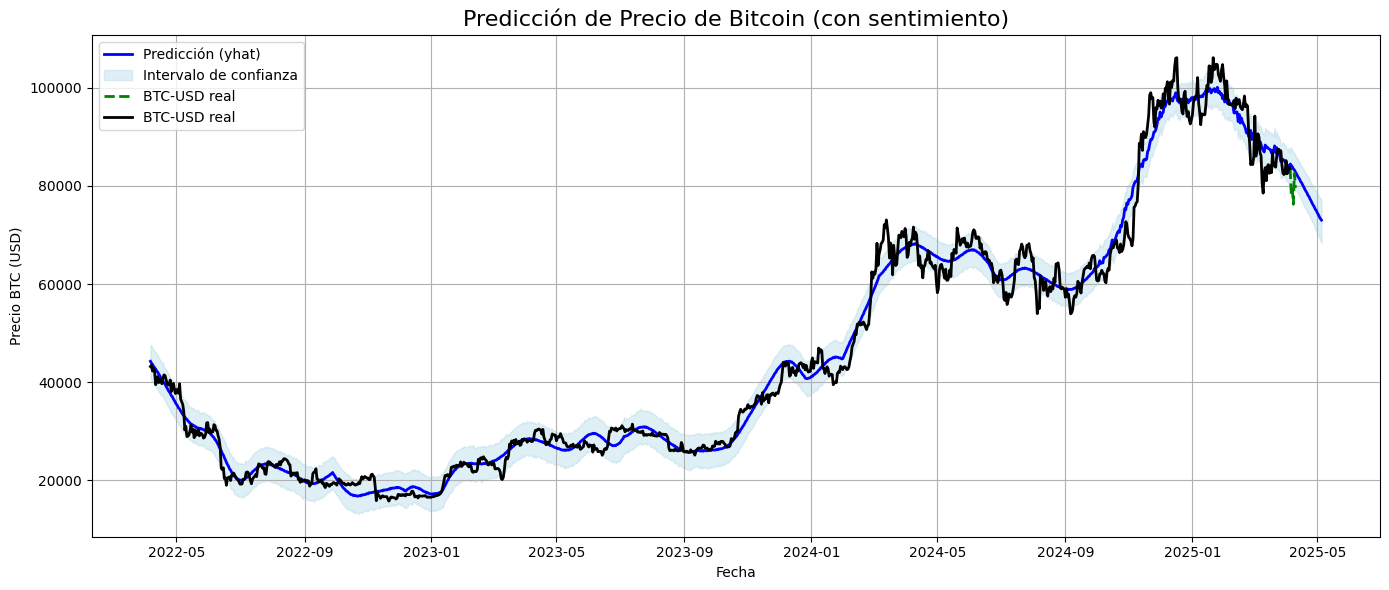

In [33]:

# Crear el modelo Prophet
modelo = Prophet(
    growth='linear',
    changepoint_prior_scale=0.09,
    changepoint_range=0.8,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    interval_width=0.80,
    uncertainty_samples=1000
)

# Añadir 'score' como regresor
modelo.add_regressor('score')

# Entrenar modelo
modelo.fit(df)

# Crear fechas futuras para predecir 7 días
futuro = modelo.make_future_dataframe(periods=30)

# Agregar score futuro (usamos último valor como aproximación)
ultimo_score = df['score'].iloc[-1]
futuro['score'] = list(df['score']) + [ultimo_score]*30

# Predecir
pronostico = modelo.predict(futuro)

# Crear figura
plt.figure(figsize=(14, 6))

# Pronóstico completo (línea azul)
plt.plot(pronostico['ds'], pronostico['yhat'], label='Predicción (yhat)', color='blue', linewidth=2)

# Banda de confianza (zona sombreada entre yhat_lower y yhat_upper)
plt.fill_between(pronostico['ds'], pronostico['yhat_lower'], pronostico['yhat_upper'],
                 color='lightblue', alpha=0.4, label='Intervalo de confianza')

# Precio real de BTC (últimos días)
plt.plot(df_btc_h['Date'], df_btc_h['Close'], label='BTC-USD real', color='green', linewidth=2, linestyle='--')
# Línea real de BTC (últimos días) en negro
plt.plot(df_btc['Date'], df_btc['Close'], label='BTC-USD real', color='black',
         linewidth=2)
# Títulos y etiquetas
plt.title('Predicción de Precio de Bitcoin (con sentimiento)', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Precio BTC (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

In [52]:
# Valor promedio últimos 7 días reales
valor_inicial = df_btc['Close'].tail(7).mean()

# Valor promedio próximos 7 días pronosticados
valor_final = pronostico['yhat'].tail(7).mean()

# Porcentaje de variación
variacion = ((valor_final - valor_inicial) / valor_inicial) * 100

# Mostrar con 2 decimales
print(f"Variación pronosticada 7 días: {variacion:.2f}%")


Variación pronosticada 7 días: -10.97%


In [53]:
# Valor promedio últimos 14 días reales
valor_inicial = df_btc['Close'].tail(14).mean()

# Valor promedio próximos 14 días pronosticados
valor_final = pronostico['yhat'].tail(14).mean()

# Porcentaje de variación
variacion = ((valor_final - valor_inicial) / valor_inicial) * 100

# Mostrar resultado
print(f"Variación pronosticada 14 días: {variacion:.2f}%")


Variación pronosticada 14 días: -10.74%


In [51]:
# Valor promedio ultimo mes
valor_inicial= df_btc['Close'].tail(30).mean()
#Valor promedio proximos 30 dias
valor_final = pronostico['yhat'].tail(30).mean()
#Comparar y sacar el porcentaje
variacion = ((valor_final - valor_inicial) / valor_inicial) * 100

print(f"Variación pronosticada 30 días: {variacion:.2f}%")

Variación pronosticada 30 días: -6.34%
